# crypto_ml scratch note
Cryptocurrency machine learning project 
## Project assumptions:
### Must have:
- Connect to cryptocurrency exchange API (Binance API) and download data
- Save data to database 
- Periodic data update
- Data analysis and prepering.
- Create a machine learning model 
- Result presentation and adapting the application to the user 

### Nice have:
- Copmarsion of different ML models
- Adding new options for user

### Vision:
- Creating a trading bot
- Creating a model based on reinforcement learning


In [1]:
# pip install requests
# pip install pandas
# pip install numpy
# pip install matplotlib
# pip install sklearn

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [31]:
api_base_endpoint = "https://api.binance.com"
api_current_price = api_base_endpoint + "/api/v3/ticker/price"
api_historical_price = api_base_endpoint + "/api/v3/klines?limit=1000&symbol=BTCUSDT&interval=1d"

In [32]:
r_current_price = requests.get(api_current_price)
r_historical_price = requests.get(api_historical_price)

In [33]:
current_price = pd.read_json(r_current_price.text)

In [127]:
current_price

,symbol,price
0,ETHBTC,0.049768
1,LTCBTC,0.004688
2,BNBBTC,0.010772
3,NEOBTC,0.001679
4,QTUMETH,0.005117
...,...,...
1423,SLPBUSD,0.358900
1424,SLPUSDT,0.358900
1425,TRXAUD,0.167300
1426,TRXEUR,0.107100


,Open,High,Low,Close,Volume
Open time,,,,,
2018-08-06,7024.19,7160.00,6821.00,6934.82,32760.191643
2018-08-07,6935.00,7150.46,6670.00,6720.06,45438.473501
2018-08-08,6720.63,6721.54,6123.00,6285.00,59550.536319
2018-08-09,6283.27,6622.81,6178.60,6529.79,51941.185111
2018-08-10,6529.79,6575.88,6026.39,6144.01,59034.974902
...,...,...,...,...,...
2021-04-27,54001.38,55460.00,53222.00,55011.97,54064.034675
2021-04-28,55011.97,56428.00,53813.16,54846.22,55130.459015
2021-04-29,54846.23,55195.84,52330.94,53555.00,52486.019455


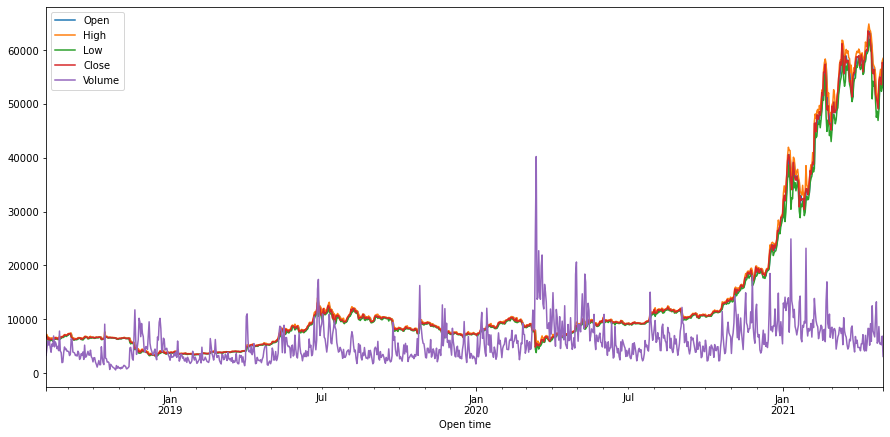

In [35]:
historical_price = pd.read_json(r_historical_price.text)

del_columns = historical_price.iloc[:,6:]
historical_price = historical_price.drop(del_columns, axis=1)
historical_price = historical_price.rename(columns={0:'Open time', 1:'Open', 2:'High', 3:'Low', 4:'Close', 5:'Volume'})
historical_price['Open time'] = pd.to_datetime(historical_price['Open time'], unit="ms")
historical_price = historical_price.set_index('Open time')

plot_price = historical_price.copy()
plot_price['Volume'] = plot_price['Volume']/10
plot_price.plot(figsize=(15,7))

historical_price

In [36]:
close_predict = historical_price.copy()

close_predict['close_3'] = close_predict['Close'].rolling(window=3).mean()
close_predict['close_9'] = close_predict['Close'].rolling(window=9).mean()
close_predict['next_day_close_price'] = close_predict['Close'].shift(-1)
close_predict = close_predict.dropna()

close_predict

,Open,High,Low,Close,Volume,close_3,close_9,next_day_close_price
Open time,,,,,,,,
2018-08-14,6248.25,6250.33,5880.00,6188.08,50186.745091,6247.586667,6398.754444,6267.16
2018-08-15,6188.08,6609.00,6172.11,6267.16,68806.687026,6233.863333,6324.570000,6311.75
2018-08-16,6265.27,6480.00,6205.60,6311.75,48515.254618,6255.663333,6279.202222,6584.49
2018-08-17,6316.00,6585.00,6285.40,6584.49,57851.610803,6387.800000,6312.478889,6387.96
2018-08-18,6579.04,6620.00,6288.00,6387.96,53742.322172,6428.066667,6296.720000,6477.53
...,...,...,...,...,...,...,...,...
2021-04-26,49066.76,54356.62,48753.44,54001.39,86310.802124,51038.666667,53103.097778,55011.97
2021-04-27,54001.38,55460.00,53222.00,55011.97,54064.034675,52693.376667,52976.648889,54846.22
2021-04-28,55011.97,56428.00,53813.16,54846.22,55130.459015,54619.860000,52889.213333,53555.00


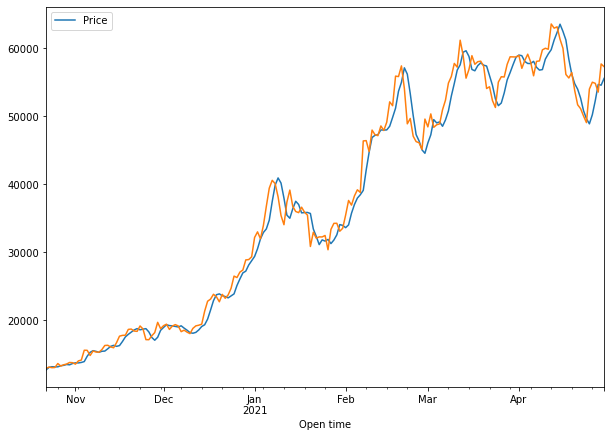

Predict score: 98.43
Crypto Price (y) = 1.23 * 3 Days Moving Average (x1) + -0.24 * 9 Days Moving Average (x2) + 71.73 (constant)


In [37]:
X = close_predict[['close_3', 'close_9']]

y = close_predict['next_day_close_price']

t = 0.8
t = int(t*len(historical_price))
X_train = X[:t]
y_train = y[:t]

X_test = X[t:]
y_test = y[t:]

model = LinearRegression()
model.fit(X_train, y_train)

predicted_price = model.predict(X_test)
predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['Price'])

predicted_price.plot(figsize=(10,7))
y_test.plot()
plt.show()

score = model.score(X[t:], y[t:])*100
print(f"Predict score: {float(score.round(2))}" )

print(f"Crypto Price (y) = {model.coef_[0].round(2)} * 3 Days Moving Average (x1) \
+ {model.coef_[1].round(2)} * 9 Days Moving Average (x2) \
+ {model.intercept_.round(2)} (constant)")

In [38]:
close_predict = historical_price.copy()

close_predict['close_3'] = close_predict['Close'].rolling(window=3).mean()
close_predict['close_9'] = close_predict['Close'].rolling(window=9).mean()
close_predict = close_predict.dropna()

close_predict['predicted_crypto_price'] = model.predict(close_predict[['close_3', 'close_9']])

close_predict.tail()

,Open,High,Low,Close,Volume,close_3,close_9,predicted_crypto_price
Open time,,,,,,,,
2021-04-27,54001.38,55460.00,53222.00,55011.97,54064.034675,52693.376667,52976.648889,52290.312512
2021-04-28,55011.97,56428.00,53813.16,54846.22,55130.459015,54619.860000,52889.213333,54680.751134
2021-04-29,54846.23,55195.84,52330.94,53555.00,52486.019455,54471.063333,52570.324444,54573.548018
2021-04-30,53555.00,57963.00,53013.01,57694.27,68578.910045,55365.163333,53004.395556,55570.116054
2021-05-01,57697.25,58458.07,56956.14,57298.02,30773.780173,56182.430000,53627.402222,56427.252719


In [51]:
mean_predict = historical_price[['Open', 'High', 'Low', 'Close']].copy()

mean_predict['mean'] = 0

for i in range(len(mean_predict)):
    mean_predict['mean'].iloc[i] = mean_predict.iloc[i,:4].mean()
    
mean_predict['next_day_price'] = mean_predict['mean'].shift(-1)
mean_predict = mean_predict.dropna()

mean_predict

C:\Users\Windows 10\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Open,High,Low,Close,mean,next_day_price
Open time,,,,,,
2018-08-06,7024.19,7160.00,6821.00,6934.82,6985.0025,6868.8800
2018-08-07,6935.00,7150.46,6670.00,6720.06,6868.8800,6462.5425
2018-08-08,6720.63,6721.54,6123.00,6285.00,6462.5425,6403.6175
2018-08-09,6283.27,6622.81,6178.60,6529.79,6403.6175,6319.0175
2018-08-10,6529.79,6575.88,6026.39,6144.01,6319.0175,6209.8700
...,...,...,...,...,...,...
2021-04-26,49066.76,54356.62,48753.44,54001.39,51544.5525,54423.8375
2021-04-27,54001.38,55460.00,53222.00,55011.97,54423.8375,55024.8375
2021-04-28,55011.97,56428.00,53813.16,54846.22,55024.8375,53982.0025


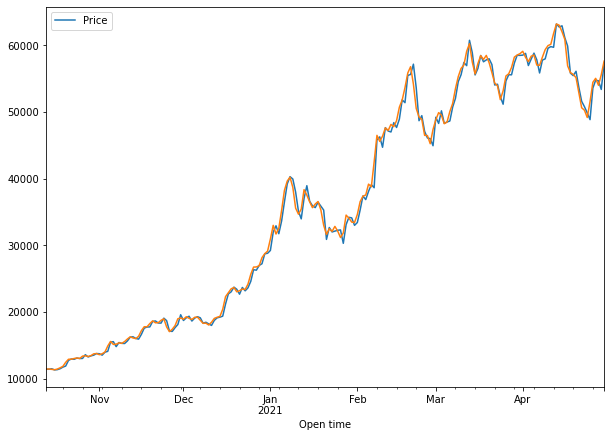

Predict score: 99.69


In [52]:
X = mean_predict[['Open', 'High', 'Low', 'Close']]
y = mean_predict['next_day_price']

t = 0.8
t = int(t*len(mean_predict))

X_train = X[:t]
y_train = y[:t]

X_test = X[t:]
y_test = y[t:]

model = LinearRegression()
model.fit(X_train, y_train)

predicted_price = model.predict(X_test)
predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['Price'])

predicted_price.plot(figsize=(10,7))
y_test.plot()
plt.show()

score = model.score(X[t:], y[t:])*100
print(f"Predict score: {float(score.round(2))}" )

In [57]:
mean_predict = historical_price.copy()

mean_predict = mean_predict.iloc[:,0:4]
mean_predict['mean'] = 0

for i in range(len(mean_predict)):
    mean_predict['mean'].iloc[i] = mean_predict.iloc[i,:4].mean()
    
mean_predict['predicted_crypto_price'] = model.predict(mean_predict[['Open', 'High', 'Low', 'Close']])
mean_predict

C:\Users\Windows 10\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Open,High,Low,Close,mean,predicted_crypto_price
Open time,,,,,,
2018-08-06,7024.19,7160.00,6821.00,6934.82,6985.0025,6941.963537
2018-08-07,6935.00,7150.46,6670.00,6720.06,6868.8800,6739.078110
2018-08-08,6720.63,6721.54,6123.00,6285.00,6462.5425,6298.106548
2018-08-09,6283.27,6622.81,6178.60,6529.79,6403.6175,6521.750089
2018-08-10,6529.79,6575.88,6026.39,6144.01,6319.0175,6160.396518
...,...,...,...,...,...,...
2021-04-27,54001.38,55460.00,53222.00,55011.97,54423.8375,54743.430700
2021-04-28,55011.97,56428.00,53813.16,54846.22,55024.8375,54659.497265
2021-04-29,54846.23,55195.84,52330.94,53555.00,53982.0025,53357.497728


In [58]:
close_predict.tail()

,Open,High,Low,Close,Volume,close_3,close_9,predicted_crypto_price
Open time,,,,,,,,
2021-04-27,54001.38,55460.00,53222.00,55011.97,54064.034675,52693.376667,52976.648889,52290.312512
2021-04-28,55011.97,56428.00,53813.16,54846.22,55130.459015,54619.860000,52889.213333,54680.751134
2021-04-29,54846.23,55195.84,52330.94,53555.00,52486.019455,54471.063333,52570.324444,54573.548018
2021-04-30,53555.00,57963.00,53013.01,57694.27,68578.910045,55365.163333,53004.395556,55570.116054
2021-05-01,57697.25,58458.07,56956.14,57298.02,30773.780173,56182.430000,53627.402222,56427.252719


In [59]:
mean_predict['move'] = np.where(
    mean_predict['predicted_crypto_price'].shift(1) < mean_predict['predicted_crypto_price'], "Buy", "Stay"
)
mean_predict.tail(1)

,Open,High,Low,Close,mean,predicted_crypto_price,move
Open time,,,,,,,
2021-05-01,57697.25,58458.07,56956.14,57298.02,57602.37,57123.254526,Stay


In [60]:
money = 10 
money_spend = 0
buys = 0
bought_coins = 0
for i in range(len(mean_predict)):
    if mean_predict['move'].iloc[i] == 'Buy':
        buys +=1
        bought_coins += money / mean_predict['mean'].iloc[i]
        money_spend += money


coin_price = mean_predict['mean'].iloc[-1]

print(f"Buys number: {buys}\nBought coins: {bought_coins}\nMoney spend: {money_spend}\nCurrent coin price: {coin_price}")
print()
fortune = bought_coins*coin_price
print(f'Fortune: {fortune.round(2)}\nProfit: {(fortune-money_spend).round(2)}')

Buys number: 542
Bought coins: 0.6730664951756912
Money spend: 5420
Current coin price: 57602.37

Fortune: 38770.23
Profit: 33350.23


In [61]:
money = 10
money_spend = 0
buys = 0
sales = 0
bought_coins = 0
for i in range(len(mean_predict)):
    if mean_predict['move'].iloc[i] == 'Buy':
        buys += 1
        bought_coins += money / mean_predict['mean'].iloc[i]
        money_spend += money
    else:
        sales += 1
        bought_coins -= money / mean_predict['mean'].iloc[i]
        money_spend -= money 

coin_price = mean_predict['mean'].iloc[-1]

print(f"Buys number: {buys}\nSales numebr: {sales}\nBuyed coins: {bought_coins}\nMoney spend: {money_spend}\nCurrent coin price: {coin_price}")
print()
fortune = bought_coins*coin_price
print(f'Fortune: {fortune.round(2)}\nProfit: {(fortune-money_spend).round(2)}')

Buys number: 542
Sales numebr: 458
Buyed coins: 0.0958984551344361
Money spend: 840
Current coin price: 57602.37

Fortune: 5523.98
Profit: 4683.98


In [62]:
def buys_sales_simulator_df(money_buys=10, money_sales=10):
    money_spend = 0
    buys = 0
    bought_coins = 0
    sales = 0
    for i in range(len(mean_predict)):
        if mean_predict['move'].iloc[i] == 'Buy':
            buys +=1
            bought_coins += money_buys / mean_predict['mean'].iloc[i]
            money_spend += money_buys
        else:
            sales += 1
            bought_coins -= money_sales / mean_predict['mean'].iloc[i]
            money_spend -= money_sales 
    coin_price = mean_predict['mean'].iloc[-1]
    fortune = (bought_coins * coin_price).round(2)
    profit = (fortune - money_spend).round(2)
    rate_of_return = ((profit / money_spend) * 100).round(2)
    df = pd.DataFrame(data={
        'Money for buys': money_buys,
        'Money for sales': money_sales,
        'Buys number': buys,
        'Sales number': sales,
        'Bought coins': bought_coins,
        'Money spend': money_spend,
        'Current coin price': coin_price,
        'Fortune': fortune,
        'profit': profit,
        'rate of return': rate_of_return,
    }, index=[0])
    return df

In [63]:
buys_sales_simulator_df(10,10)

,Money for buys,Money for sales,Buys number,Sales number,Bought coins,Money spend,Current coin price,Fortune,profit,rate of return
0,10,10,542,458,0.095898,840,57602.37,5523.98,4683.98,557.62


In [64]:
# df = pd.DataFrame(data=buys_sales_simulator_df(1,1))
# for i in range(1,101):
#     for j in range(101):
#         df = df.append(pd.DataFrame(data=buys_sales_simulator_df(i,j)))
# df = df.reset_index()
# df = df.drop([0])
# df = df.drop('index', axis=1)
# df.to_csv('buys_sales_simulation_df_BTCUSDT_1d.csv', index=False)
# df

In [65]:
df = pd.read_csv('buys_sales_simulation_df_BTCUSDT_1m.csv')
df['Minus number'] = np.where(df['Money spend'] <0, None, 0)
df = df.dropna()
df = df.drop('Minus number', axis=1)
df.loc[df['profit'] == df['profit'].max()]

,Money for buys,Money for sales,Buys number,Sales number,Bought coins,Money spend,Current coin price,Fortune,profit
9998,99,100,505,495,0.008807,495,57351.7975,505.12,10.12


In [66]:
df = pd.read_csv('buys_sales_simulation_df_BTCUSDT_1h.csv')
df.loc[df['profit'] == df['profit'].max()]

,Money for buys,Money for sales,Buys number,Sales number,Bought coins,Money spend,Current coin price,Fortune,profit
9999,100,0,496,504,0.879223,49600,57491.1875,50547.57,947.57


In [67]:
df = pd.read_csv('buys_sales_simulation_df_BTCUSDT_1d.csv')
df.loc[df['profit'] == df['profit'].max()]

,Money for buys,Money for sales,Buys number,Sales number,Bought coins,Money spend,Current coin price,Fortune,profit
9999,100,0,543,457,6.732396,54300,57758.7625,388854.88,334554.88


In [144]:
api_base_endpoint = "https://api.binance.com"
btc_api = api_base_endpoint + "/api/v3/klines?limit=1000&symbol=BTCUSDT&interval=1d"
eth_api = api_base_endpoint + "/api/v3/klines?limit=1000&symbol=ETHUSDT&interval=1d"
lsk_api = api_base_endpoint + "/api/v3/klines?limit=1000&symbol=LSKUSDT&interval=1d"
ethbtc_api = api_base_endpoint + "/api/v3/klines?limit=1000&symbol=ETHBTC&interval=1d"
r_btc = requests.get(btc_api)
r_eth = requests.get(eth_api)
r_lsk = requests.get(lsk_api)
r_ethbtc = requests.get(ethbtc_api)
btc_df = pd.read_json(r_btc.text)
eth_df = pd.read_json(r_eth.text)
lsk_df = pd.read_json(r_lsk.text)
ethbtc_df = pd.read_json(r_ethbtc.text)

In [145]:
def prepare_data(data):
    data = data.copy()
    del_columns = data.iloc[:,5:]
    data = data.drop(del_columns, axis=1)
    data = data.rename(columns={0:'Open time', 1:'Open', 2:'High', 3:'Low', 4:'Close'})
    data['Open time'] = pd.to_datetime(data['Open time'], unit="ms")
    data = data.set_index('Open time')

    return data

In [146]:
btc_df = prepare_data(btc_df)
eth_df = prepare_data(eth_df)
lsk_df = prepare_data(lsk_df)
ethbtc_df = prepare_data(ethbtc_df)

,BTC,ETH,LSK,ETHBTC
Open time,,,,
2018-08-06,693.482,810.56,NaN,2920.00
2018-08-07,672.006,756.42,NaN,2813.80
2018-08-08,628.500,710.96,NaN,2828.00
2018-08-09,652.979,726.60,NaN,2783.85
2018-08-10,614.401,663.62,NaN,2698.40
...,...,...,...,...
2021-04-27,5501.197,5332.26,2440.50,2422.85
2021-04-28,5484.622,5496.48,2824.35,2505.70
2021-04-29,5355.500,5514.08,2649.70,2574.60


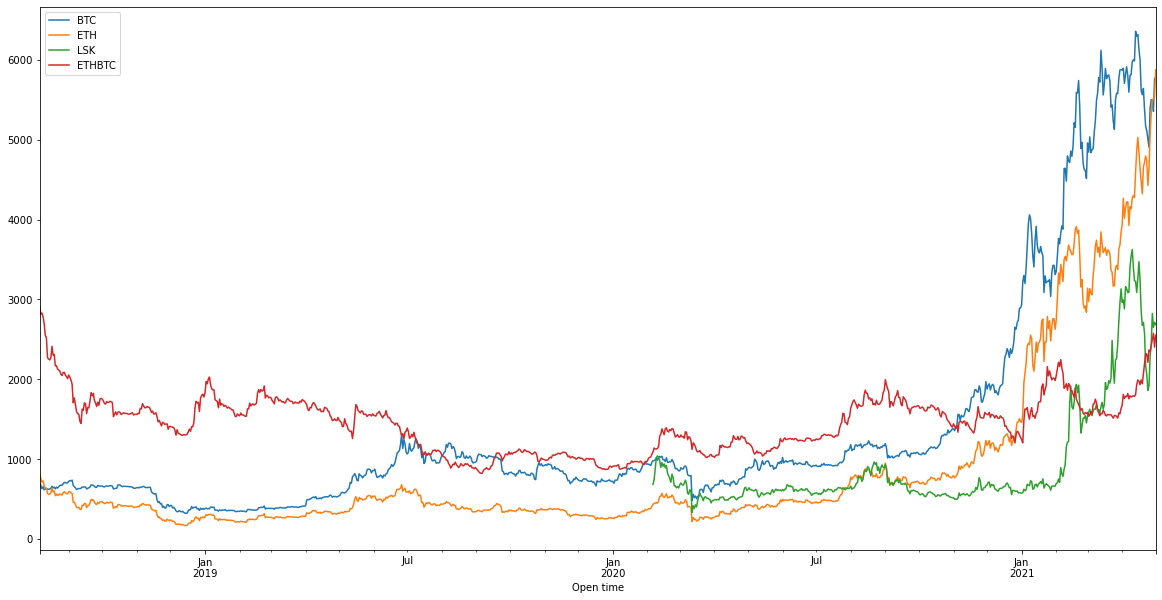

In [155]:
test_df = pd.DataFrame(data={'BTC':btc_df['Close'], 'ETH':eth_df['Close'],'LSK':lsk_df['Close'], 'ETHBTC':ethbtc_df['Close']})
test_df['BTC'] = test_df['BTC']/10
test_df['ETHBTC'] = test_df['ETHBTC']*50000
test_df['ETH'] = test_df['ETH']*2
test_df['LSK'] = test_df['LSK']*500

test_df.plot(figsize=(20,10))

test_df

In [154]:
test_df.corr()

,BTC,ETH,LSK,ETHBTC
BTC,1.000000,0.976697,0.841898,0.308094
ETH,0.976697,1.000000,0.848411,0.447551
LSK,0.841898,0.848411,1.000000,0.514675
ETHBTC,0.308094,0.447551,0.514675,1.000000


C:\Users\Windows 10\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


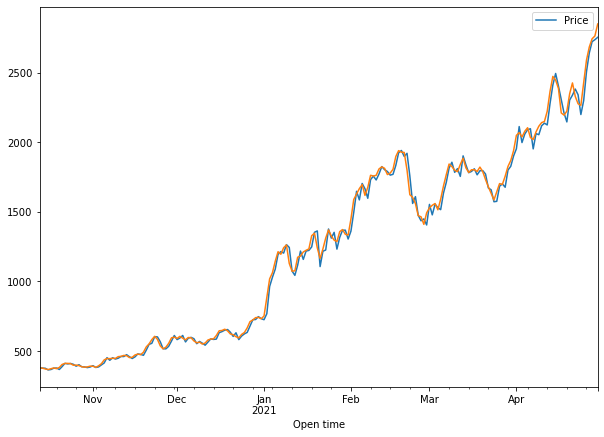

Predict score: 99.62


In [156]:
mean_predict = eth_df[['Open', 'High', 'Low', 'Close']].copy()

mean_predict['mean'] = 0

for i in range(len(mean_predict)):
    mean_predict['mean'].iloc[i] = mean_predict.iloc[i,:4].mean()
    
mean_predict['next_day_price'] = mean_predict['mean'].shift(-1)
mean_predict = mean_predict.dropna()

mean_predict

X = mean_predict[['Open', 'High', 'Low', 'Close']]
y = mean_predict['next_day_price']

t = 0.8
t = int(t*len(mean_predict))

X_train = X[:t]
y_train = y[:t]

X_test = X[t:]
y_test = y[t:]

model = LinearRegression()
model.fit(X_train, y_train)

predicted_price = model.predict(X_test)
predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['Price'])

predicted_price.plot(figsize=(10,7))
y_test.plot()
plt.show()

score = model.score(X[t:], y[t:])*100
print(f"Predict score: {float(score.round(2))}" )

In [157]:
mean_predict = eth_df.copy()

mean_predict = mean_predict.iloc[:,0:4]
mean_predict['mean'] = 0

for i in range(len(mean_predict)):
    mean_predict['mean'].iloc[i] = mean_predict.iloc[i,:4].mean()
    
mean_predict['predicted_crypto_price'] = model.predict(mean_predict[['Open', 'High', 'Low', 'Close']])
mean_predict

C:\Users\Windows 10\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Open,High,Low,Close,mean,predicted_crypto_price
Open time,,,,,,
2018-08-06,408.77,413.28,397.08,405.28,406.1025,403.716748
2018-08-07,405.19,412.76,369.19,378.21,391.3375,377.062259
2018-08-08,378.20,380.42,347.25,355.48,365.3375,354.417305
2018-08-09,355.48,369.90,350.51,363.30,359.7975,361.785384
2018-08-10,363.21,365.87,325.95,331.81,346.7100,331.116349
...,...,...,...,...,...,...
2021-04-27,2532.06,2680.00,2480.29,2666.13,2589.6200,2640.966371
2021-04-28,2666.13,2760.00,2559.44,2748.24,2683.4525,2722.297313
2021-04-29,2748.23,2798.00,2668.00,2757.04,2742.8175,2736.236139


In [159]:
mean_predict['move'] = np.where(
    mean_predict['predicted_crypto_price'].shift(1) < mean_predict['predicted_crypto_price'], "Buy", "Stay"
)
mean_predict.tail()

,Open,High,Low,Close,mean,predicted_crypto_price,move
Open time,,,,,,,
2021-04-27,2532.06,2680.00,2480.29,2666.13,2589.6200,2640.966371,Buy
2021-04-28,2666.13,2760.00,2559.44,2748.24,2683.4525,2722.297313,Buy
2021-04-29,2748.23,2798.00,2668.00,2757.04,2742.8175,2736.236139,Buy
2021-04-30,2757.04,2798.30,2723.09,2772.42,2762.7125,2753.319388,Buy
2021-05-01,2772.42,2943.24,2743.41,2937.57,2849.1600,2910.133717,Buy


In [160]:
df = pd.DataFrame(data=buys_sales_simulator_df(1,1))
for i in range(1,101):
    for j in range(101):
        df = df.append(pd.DataFrame(data=buys_sales_simulator_df(i,j)))
df = df.reset_index()
df = df.drop([0])
df = df.drop('index', axis=1)
df.to_csv('buys_sales_simulation_df_ETHUSDT_1d.csv', index=False)
df

,Money for buys,Money for sales,Buys number,Sales number,Bought coins,Money spend,Current coin price,Fortune,profit,rate of return
1,1,0,526,474,2.284457,526,2849.16,6508.78,5982.78,1137.41
2,1,1,526,474,0.012368,52,2849.16,35.24,-16.76,-32.23
3,1,2,526,474,-2.259721,-422,2849.16,-6438.31,-6016.31,1425.67
4,1,3,526,474,-4.531809,-896,2849.16,-12911.85,-12015.85,1341.05
5,1,4,526,474,-6.803898,-1370,2849.16,-19385.39,-18015.39,1314.99
...,...,...,...,...,...,...,...,...,...,...
10096,100,96,526,474,10.325167,7096,2849.16,29418.05,22322.05,314.57
10097,100,97,526,474,8.053078,6622,2849.16,22944.51,16322.51,246.49
10098,100,98,526,474,5.780989,6148,2849.16,16470.96,10322.96,167.91
10099,100,99,526,474,3.508901,5674,2849.16,9997.42,4323.42,76.20


In [162]:
df = pd.read_csv('buys_sales_simulation_df_ETHUSDT_1d.csv')
df['Minus number'] = np.where(df['Money spend'] <0, None, 0)
df = df.dropna()
df = df.drop('Minus number', axis=1)
df.loc[df['profit'] == df['profit'].max()]

,Money for buys,Money for sales,Buys number,Sales number,Bought coins,Money spend,Current coin price,Fortune,profit,rate of return
9999,100,0,526,474,228.44568,52600,2849.16,650878.29,598278.29,1137.41
